In [62]:
# Environmental Equity in Toronto Wards: Access to Green Infrastructure in Black and Minority Communities

In [63]:
# Urban Tree Equity Study: Toronto Case
# Author: Emily Brewer, G.I.T

# This notebook explores the correlation between urban tree cover and the Black and Minority population percentage across Toronto wards used GIS and 
# demographic data. The goal is to assess environmental equity through spatial analysis.

In [109]:
# Data Sources

#- Toronto ward boundaries: https://open.toronto.ca/dataset/city-wards/
#- Population data by ward: Canada Census Data
#- Tree cover: https://open.toronto.ca/dataset/forest-and-land-cover/

In [65]:
import arcpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [110]:
arcpy.env.workspace = r"C:\Users\Emilie\OneDrive\Documents\ArcGIS\Projects\Parks-TreeCover-BlackWards_TO\Parks-TreeCover-BlackWards_TO.gdb"
arcpy.env.overwriteOutput = True

wards = "City Wards Data - 4326"
blackpop_stats = "Black Population of Toronto Wards"

In [67]:
#Calculating Total Population of each ward

arcpy.management.AddField(wards, "WardPop", "LONG")

arcpy.management.CalculateField(
    in_table=wards,
    field="WardPop",
    expression="(!MinorityPop! + !WhitePop!)",
    expression_type="PYTHON3"
)


#Calculating Percentage of Black Persons in each ward

arcpy.management.AddField(wards, "BlackPercent", "LONG")

arcpy.management.CalculateField(
    in_table=wards,
    field="BlackPercent",
    expression="(!BlackPop! / !WardPop!) * 100",
    expression_type="PYTHON3"
)

<class 'arcgisscripting.ExecuteError'>: Failed to execute. Parameters are not valid.
ERROR 000732: Input Table: Dataset City Wards Data - 4326 does not exist or is not supported
Failed to execute (AddField).


In [ ]:
# Visualizing Black Population in Toronto

# Each ward is colored by the % of Black population using 4 categories:
#- 0–10%
#- 11-15%
#- 15-20%
#- >21%

# I start at 0-10% since the black population average in Toronto is 9.6% (and my data gave rounded percents).
# I wanted to focus on areas that were especially black, so places with a black population of less than 10% are excluded.

In [68]:
# Setting Co-ordinate Systems to Modified Transverse Mercator (MTM) projection, North American Datum 1927 (NAD27).
# This Co-ordinate System is the standard in Toronto spatial analysis.

out_coord = arcpy.SpatialReference("NAD_1983_CSRS_MTM_10")

arcpy.management.Project(wards, "CityWardsData_MTM.shp", out_coord)

<class 'arcgisscripting.ExecuteError'>: Failed to execute. Parameters are not valid.
ERROR 000732: Input Dataset or Feature Class: Dataset City Wards Data - 4326 does not exist or is not supported
WARNING 000725: Output Dataset or Feature Class: Dataset C:\Users\Emilie\OneDrive\Documents\ArcGIS\Projects\Parks-TreeCover-BlackWards_TO\CityWardsData_MTM.shp already exists.
Failed to execute (Project).


In [69]:
# Joining Black Pop table to shapefile of Toronto Wards

wards_MTM = "CityWardsData_MTM.shp"

joined_MTM = arcpy.management.AddJoin(wards_MTM, "_id1", blackpop_stats, "_id1")

result = arcpy.management.CopyFeatures(joined_MTM, "CityWards_BlackStats_MTM")

In [70]:
#Plotting the Black Population for each ward

fields = ["BlackPop_TorontoWards.Ward", "BlackPop_TorontoWards.BlackPop", "BlackPop_TorontoWards.WardPop", "BlackPop_TorontoWards.BlackPercent"]
data = [row for row in arcpy.da.SearchCursor(wards, fields)]
df = pd.DataFrame(data, columns=fields)


#Histogram
plt.figure(figsize=(6,4))
plt.hist(df["BlackPop_TorontoWards.BlackPercent"], bins=10, color='mediumslateblue', edgecolor='black')

plt.axvline(x=9.6, color='blue', linestyle=':', linewidth=2, label='Toronto Black Pop. Average (9.6%)')
plt.legend()

plt.title("Distribution of Black Population % by Ward")
plt.xlabel("Percent of Population Identifying as Black")
plt.ylabel("Number of Toronto Wards")
plt.show()

<class 'RuntimeError'>: cannot open 'City Wards Data - 4326'

In [71]:
#Narrowing down landcover values to just areas covered by trees

treecover = "LandCover2018 3 categories"

treeselection = arcpy.management.SelectLayerByAttribute(treecover, 
                                                        "NEW_SELECTION", 
                                                        '"Desc" = \'tree\'')
arcpy.management.CopyFeatures(treeselection, "Tree_Cover")

<class 'arcgisscripting.ExecuteError'>: Failed to execute. Parameters are not valid.
ERROR 000732: Layer Name or Table View: Dataset LandCover2018 3 categories does not exist or is not supported
Failed to execute (SelectLayerByAttribute).


In [72]:
#Assigning trees to their ward for further analysis

tree_per_ward = arcpy.analysis.SpatialJoin("Tree_Cover", "CityWards_BlackStats_MTM", "CityWards_TreesPerWard", "JOIN_ONE_TO_ONE")

In [73]:
#Tree Areas
fields = ["BlackPop_TorontoWards_Ward", "Shape_Area"]
tree_data = [row for row in arcpy.da.SearchCursor("CityWards_TreesPerWard", fields)]
df_trees = pd.DataFrame(tree_data, columns=["BlackPop_TorontoWards_Ward", "Shape_Area"])

#Ward Areas
ward_data = [row for row in arcpy.da.SearchCursor("CityWards_BlackStats_MTM", ["BlackPop_TorontoWards_Ward", "Shape_Area"])]
df_wards = pd.DataFrame(ward_data, columns=["BlackPop_TorontoWards_Ward", "Shape_Area"])

#Merging trees in each ward and calculating percentage of tree cover in each ward
grouped_tree = df_trees.groupby("BlackPop_TorontoWards_Ward")["Shape_Area"].sum().reset_index()
grouped_tree.columns = ["Ward", "TotalTreeArea"]
df_wards.columns = ["Ward", "WardArea"]

df_final = pd.merge(df_wards, grouped_tree, on="Ward", how="left")
df_final["TreeCoverPercent"] = (df_final["TotalTreeArea"] / df_final["WardArea"]) * 100

print(df_final[["Ward", "TreeCoverPercent"]])

                             Ward  TreeCoverPercent
0        Humber River-Black Creek         30.663711
1                     York Centre         20.458462
2                      Willowdale         32.810216
3             University-Rosedale         53.837609
4               Beaches-East York         49.662467
5           Scarborough Southwest         31.015683
6          Scarborough-Rouge Park         43.547263
7               Scarborough North         12.319927
8           Scarborough-Guildwood         23.874676
9              Scarborough Centre         15.985656
10          Scarborough-Agincourt         17.181397
11                Don Valley West         50.880253
12             Toronto-St. Paul's         34.723632
13  Taiaiako'n-Parkdale-High Park         38.955955
14                Etobicoke North         13.053909
15            Etobicoke-Lakeshore         29.685382
16               Etobicoke Centre         22.268161
17              Eglinton-Lawrence         24.154024
18          

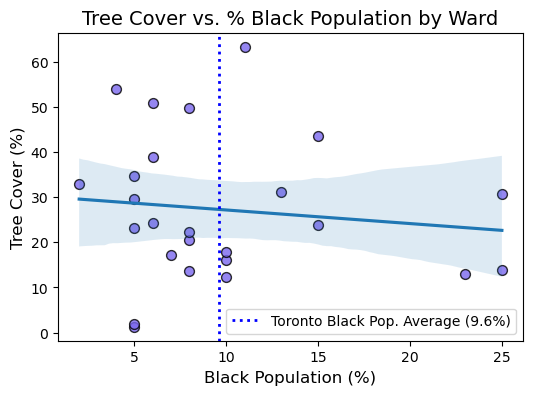

In [85]:
fields = ["BlackPop_TorontoWards_Ward", "BlackPop_TorontoWards_BlackPercent"]
pop_data = [row for row in arcpy.da.SearchCursor("CityWards_BlackStats_MTM", fields)]
df_stats = pd.DataFrame(pop_data, columns=fields)

df_final = df_final.rename(columns={"Ward": "BlackPop_TorontoWards_Ward"})
df_combined_black = pd.merge(df_final, df_stats, on="BlackPop_TorontoWards_Ward", how="left")

plt.figure(figsize=(6, 4))
sns.regplot(
    data=df_combined_black,
    x="BlackPop_TorontoWards_BlackPercent",
    y="TreeCoverPercent",
    scatter_kws={"color": "mediumslateblue", "edgecolor": "black", "s": 50},
)

plt.title("Tree Cover vs. % Black Population by Ward", fontsize=14)
plt.xlabel("Black Population (%)", fontsize=12)
plt.ylabel("Tree Cover (%)", fontsize=12)

plt.axvline(9.6, color="blue", linewidth=2, linestyle=":", label="Toronto Black Pop. Average (9.6%)")
plt.legend()

plt.show()

In [86]:
x = df_combined_black["BlackPop_TorontoWards_BlackPercent"]
y = df_combined_black["TreeCoverPercent"]

corr_coef, p_value = pearsonr(x, y)

print(f"Pearson correlation coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: -0.120
P-value: 0.567


In [77]:
# Displaying a weak negative correlation - meaning that as the percentage of black residents increases, tree cover slightly decreases.

# Calculating Minority Percent to see if this is the same or different.

city_wards = "CityWards_BlackStats_MTM"

arcpy.management.AddField(city_wards, "MinorityPercent", "LONG")

arcpy.management.CalculateField(
    in_table=city_wards,
    field="MinorityPercent",
    expression="(!BlackPop_TorontoWards_MinorityPop! / !BlackPop_TorontoWards_WardPop! * 100)",
    expression_type="PYTHON3"
)

<Result 'CityWards_BlackStats_MTM'>

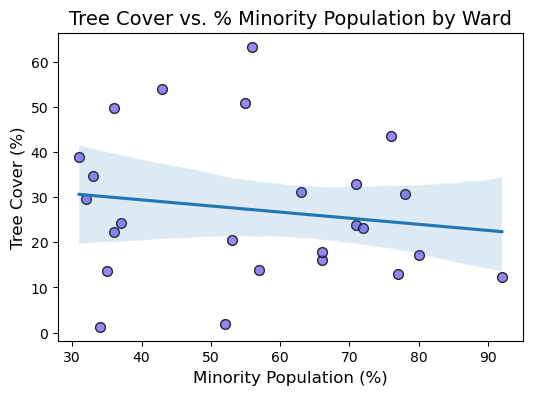

In [78]:
fields = ["BlackPop_TorontoWards_Ward", "BlackPop_TorontoWards_MinorityPercent"]
pop_data = [row for row in arcpy.da.SearchCursor(city_wards, fields)]
df_stats = pd.DataFrame(pop_data, columns=fields)

df_final = df_final.rename(columns={"Ward": "BlackPop_TorontoWards_Ward"})
df_combined_minority = pd.merge(df_final, df_stats, on="BlackPop_TorontoWards_Ward", how="left")

plt.figure(figsize=(6, 4))
sns.regplot(
    data=df_combined_minority,
    x="BlackPop_TorontoWards_MinorityPercent",
    y="TreeCoverPercent",
    scatter_kws={"color": "mediumslateblue", "edgecolor": "black", "s": 50},
)

plt.title("Tree Cover vs. % Minority Population by Ward", fontsize=14)
plt.xlabel("Minority Population (%)", fontsize=12)
plt.ylabel("Tree Cover (%)", fontsize=12)

plt.show()

In [79]:
x = df_combined_minority["BlackPop_TorontoWards_MinorityPercent"]
y = df_combined_minority["TreeCoverPercent"]

corr_coef, p_value = pearsonr(x, y)

print(f"Pearson correlation coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: -0.156
P-value: 0.455


In [80]:
# A bit more negative, but nothing extremely important.

# Looking for Outliers in the data.

data = {
    "Ward": [
        "Humber River-Black Creek", "York Centre", "Willowdale", "University-Rosedale", 
        "Beaches-East York", "Scarborough Southwest", "Scarborough-Rouge Park", 
        "Scarborough North", "Scarborough-Guildwood", "Scarborough Centre", 
        "Scarborough-Agincourt", "Don Valley West", "Toronto-St. Paul's", 
        "Taiaiako'n-Parkdale-High Park", "Etobicoke North", "Etobicoke-Lakeshore", 
        "Etobicoke Centre", "Eglinton-Lawrence", "Don Valley North", "Don Valley East", 
        "Davenport", "Toronto Centre", "York South-Weston", "Toronto-Danforth", 
        "Spadina-Harbourfront"
    ],
    "TreeCoverPercent": [
        30.663711, 20.458462, 32.810216, 53.837609, 49.662467, 31.015683, 43.547263, 
        12.319927, 23.874676, 15.985656, 17.181397, 50.880253, 34.723632, 38.955955, 
        13.053909, 29.685382, 22.268161, 24.154024, 23.201560, 17.951169, 13.663826, 
        63.281982, 13.768730, 1.303377, 1.928007
    ]
}

df = pd.DataFrame(data)

# Calculate Q1, Q3, and IQR
Q1 = df["TreeCoverPercent"].quantile(0.25)
Q3 = df["TreeCoverPercent"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier criteria
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df["TreeCoverPercent"] < lower_bound) | (df["TreeCoverPercent"] > upper_bound)]

print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print("\nOutliers:")
print(outliers)

Lower Bound: -12.121308000000004
Upper Bound: 62.83059600000001

Outliers:
              Ward  TreeCoverPercent
21  Toronto Centre         63.281982


In [88]:
df_no_outlier_black = df_combined_black[df_combined_black["BlackPop_TorontoWards_Ward"] != "Toronto Centre"]

df_no_outlier_minority = df_combined_minority[df_combined_minority["BlackPop_TorontoWards_Ward"] != "Toronto Centre"]

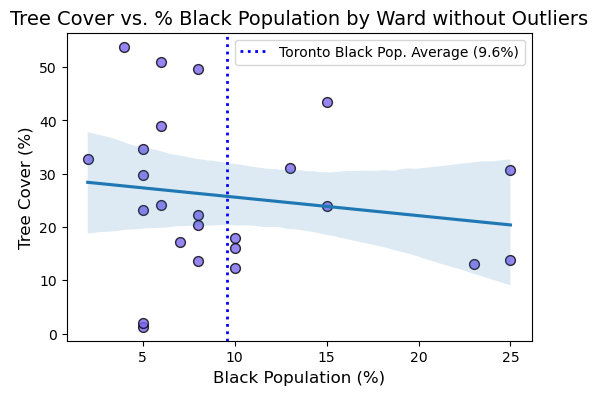

Pearson correlation coefficient: -0.157
P-value: 0.463


In [89]:
plt.figure(figsize=(6, 4))
sns.regplot(
    data=df_no_outlier_black,
    x="BlackPop_TorontoWards_BlackPercent",
    y="TreeCoverPercent",
    scatter_kws={"color": "mediumslateblue", "edgecolor": "black", "s": 50},
)

plt.title("Tree Cover vs. % Black Population by Ward without Outliers", fontsize=14)
plt.xlabel("Black Population (%)", fontsize=12)
plt.ylabel("Tree Cover (%)", fontsize=12)

plt.axvline(9.6, color="blue", linewidth=2, linestyle=":", label="Toronto Black Pop. Average (9.6%)")
plt.legend()

plt.show()

x = df_no_outlier_black["BlackPop_TorontoWards_BlackPercent"]
y = df_no_outlier_black["TreeCoverPercent"]

corr_coef, p_value = pearsonr(x, y)

print(f"Pearson correlation coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value:.3f}")

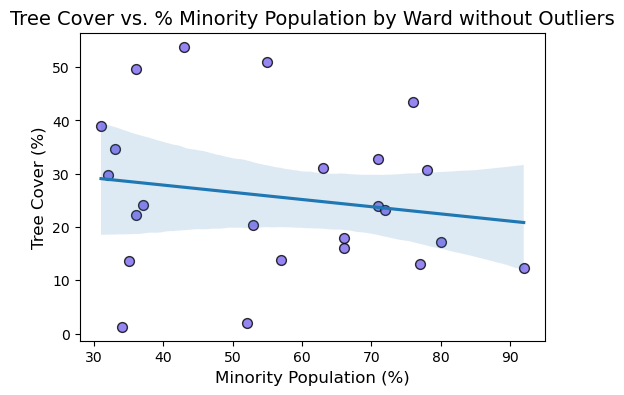

Pearson correlation coefficient: -0.177
P-value: 0.409


In [84]:
plt.figure(figsize=(6, 4))
sns.regplot(
    data=df_no_outlier_minority,
    x="BlackPop_TorontoWards_MinorityPercent",
    y="TreeCoverPercent",
    scatter_kws={"color": "mediumslateblue", "edgecolor": "black", "s": 50},
)

plt.title("Tree Cover vs. % Minority Population by Ward without Outliers", fontsize=14)
plt.xlabel("Minority Population (%)", fontsize=12)
plt.ylabel("Tree Cover (%)", fontsize=12)

plt.show()

x = df_no_outlier_minority["BlackPop_TorontoWards_MinorityPercent"]
y = df_no_outlier_minority["TreeCoverPercent"]

corr_coef, p_value = pearsonr(x, y)

print(f"Pearson correlation coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value:.3f}")

In [ ]:
# In general, there is a very weak negative correlation between minority and black populations with tree cover.
# This shows that as black or minority populations increase in Toronto, tree cover slightly decreases.

In [107]:
# Let's do an equity score analysis on each ward!

ward = "BlackPop_TorontoWards_Ward"


df_equity_minority = df_no_outlier_minority[[ward, "TreeCoverPercent", "BlackPop_TorontoWards_MinorityPercent"]].copy()
df_equity_minority["EquityScore_Minority"] = (df_equity_minority["TreeCoverPercent"] - df_equity_minority["BlackPop_TorontoWards_MinorityPercent"])

df_equity_black = df_no_outlier_black[[ward, "TreeCoverPercent", "BlackPop_TorontoWards_BlackPercent"]].copy()
df_equity_black["EquityScore_Black"] = (df_equity_black["TreeCoverPercent"] - df_equity_black["BlackPop_TorontoWards_BlackPercent"])


df_equity = pd.merge(
    df_equity_minority[[ward, "EquityScore_Minority"]],
    df_equity_black[[ward, "EquityScore_Black"]],
    on=ward,
    how="inner"
)

df_equity = df_equity[[ward, "EquityScore_Minority", "EquityScore_Black"]]

df_equity.rename(columns={
    "BlackPop_TorontoWards_Ward": "Ward",
    "EquityScore_Minority": "Minority Equity Score",
    "EquityScore_Black": "Black Equity Score"
                         }, inplace=True)

print(df_equity)

                             Ward  Minority Equity Score  Black Equity Score
0        Humber River-Black Creek             -47.336289            5.663711
1                     York Centre             -32.541538           12.458462
2                      Willowdale             -38.189784           30.810216
3             University-Rosedale              10.837609           49.837609
4               Beaches-East York              13.662467           41.662467
5           Scarborough Southwest             -31.984317           18.015683
6          Scarborough-Rouge Park             -32.452737           28.547263
7               Scarborough North             -79.680073            2.319927
8           Scarborough-Guildwood             -47.125324            8.874676
9              Scarborough Centre             -50.014344            5.985656
10          Scarborough-Agincourt             -62.818603           10.181397
11                Don Valley West              -4.119747           44.880253

In [ ]:
#Making Shape Area into Km

arcpy.management.AddField(city_wards, "Shape_Area_KM", "LONG")

arcpy.management.CalculateField(
    in_table=city_wards,
    field="Shape_Area_KM",
    expression="(!Shape_Area! / 1000)",
    expression_type="PYTHON3"
)

#Calculating Population Density

arcpy.management.AddField(city_wards, "PopDensity", "LONG")

arcpy.management.CalculateField(
    in_table=city_wards,
    field="PopDensity",
    expression="(!BlackPop_TorontoWards_WardPop! / !Shape_Area_KM!)",
    expression_type="PYTHON3"
)

In [ ]:
#Displaying Population Density in DataFrames

fields = ["BlackPop_TorontoWards_Ward", "PopDensity", "BlackPop_TorontoWards_BlackPercent"]

density_data = [row for row in arcpy.da.SearchCursor(city_wards, fields)]

df_density = pd.DataFrame(density_data, columns=fields)

df_density = df_density.rename(columns={
    "BlackPop_TorontoWards_Ward": "Ward",
    "PopDensity": "Population Density",
   "BlackPop_TorontoWards_BlackPercent": "Black Population %"})

print(df_density)